# Apache Spark Koalas

Este notebook contiene las funciones principales de Koalas, obtenidas de la documentación oficial de https://koalas.readthedocs.io/

In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyspark==2.4.4

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install koalas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
sys.executable

'c:\\Users\\ilse-\\anaconda3\\envs\\bigdata2\\python.exe'

In [7]:
import findspark
findspark.init()

import pandas as pd
import pyspark

import pandas as pd
import numpy as np
import databricks.koalas as ks
from pyspark.sql import SparkSession

### 1. Creación de objetos



Creando una serie Koalas pasando una lista de valores, permitiendo que Koalas cree un índice entero predeterminado:

In [8]:
s = ks.Series([1, 3, 5, np.nan, 6, 8])

In [9]:
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

Creando un Koalas DataFrame pasando un dict de objetos que se pueden convertir a series.

In [10]:
kdf = ks.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [11]:
kdf

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


Creando un DataFrame de pandas pasando una matriz numpy, con un índice de fecha y hora y columnas etiquetadas:

In [12]:
dates = pd.date_range('20130101', periods=6)

In [13]:
dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06'],
              dtype='datetime64[ns]', freq='D')

In [14]:
pdf = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))

In [15]:
pdf

,A,B,C,D
2013-01-01,0.844484,0.759189,0.839813,-1.348347
2013-01-02,2.261903,0.898440,3.788530,0.700702
2013-01-03,1.409467,-3.410261,0.184204,0.279708
2013-01-04,1.021139,-0.968900,1.286161,0.605943
2013-01-05,-1.226135,-0.422710,-0.013699,0.771648
2013-01-06,1.122709,0.464276,1.198451,0.026688


Ahora, este DataFrame de pandas se puede convertir en un DataFrame de Koalas

In [16]:
kdf = ks.from_pandas(pdf)

In [17]:
type(kdf)

databricks.koalas.frame.DataFrame

Sin embargo, se ve y se comporta igual que un DataFrame de pandas

In [18]:
kdf

,A,B,C,D
2013-01-01,0.844484,0.759189,0.839813,-1.348347
2013-01-02,2.261903,0.898440,3.788530,0.700702
2013-01-03,1.409467,-3.410261,0.184204,0.279708
2013-01-04,1.021139,-0.968900,1.286161,0.605943
2013-01-05,-1.226135,-0.422710,-0.013699,0.771648
2013-01-06,1.122709,0.464276,1.198451,0.026688


Además, es posible crear un **Koalas DataFrame desde Spark DataFrame**.

Creando un Spark DataFrame a partir de pandas DataFrame

In [19]:
spark = SparkSession.builder.getOrCreate()

In [20]:
sdf = spark.createDataFrame(pdf)

In [21]:
sdf.show()

+-------------------+-------------------+--------------------+-------------------+
|                  A|                  B|                   C|                  D|
+-------------------+-------------------+--------------------+-------------------+
| 0.8444839571317416| 0.7591890786074168|  0.8398129524586214| -1.348347437511283|
| 2.2619029044442787| 0.8984397204187033|  3.7885296858165005| 0.7007019235969093|
| 1.4094669573887761|-3.4102611972263484|  0.1842040749620267|0.27970838277196747|
|  1.021139251160552|-0.9689003210570012|  1.2861605900405857| 0.6059429286649378|
|-1.2261348804937677|-0.4227095417608676|-0.01369943940286...| 0.7716484709659582|
|   1.12270883456703|0.46427645814661017|  1.1984514963642496|0.02668842101786151|
+-------------------+-------------------+--------------------+-------------------+



Creando Koalas DataFrame desde Spark DataFrame.
`to_koalas ()` se adjunta automáticamente a Spark DataFrame y está disponible como una API cuando se importa Koalas.

In [22]:
kdf = sdf.to_koalas()

In [23]:
kdf

,A,B,C,D
0,0.844484,0.759189,0.839813,-1.348347
1,2.261903,0.898440,3.788530,0.700702
2,1.409467,-3.410261,0.184204,0.279708
3,1.021139,-0.968900,1.286161,0.605943
4,-1.226135,-0.422710,-0.013699,0.771648
5,1.122709,0.464276,1.198451,0.026688


Tiene [dtypes] específicos. Actualmente se admiten los tipos que son comunes a Spark y pandas.

In [24]:
kdf.dtypes

A    float64
B    float64
C    float64
D    float64
dtype: object

### 2. Manipulación de datos


A diferencia de los pandas, los datos en un dataframe de datos de Spark no están _ordenados_, no tienen una noción intrínseca de índice. Cuando se le solicite el encabezado, Spark solo tomará el número solicitado de filas de una partición. **No hay que utilizar el df de Koalas para devolver filas específicas**, use `.loc` o` iloc` en su lugar.

In [25]:
kdf.head()

,A,B,C,D
0,0.844484,0.759189,0.839813,-1.348347
1,2.261903,0.898440,3.788530,0.700702
2,1.409467,-3.410261,0.184204,0.279708
3,1.021139,-0.968900,1.286161,0.605943
4,-1.226135,-0.422710,-0.013699,0.771648


Muestre el índice, las columnas y los datos numéricos subyacentes.

También puede recuperar el índice; la columna de índice se puede atribuir a un DataFrame, ver más adelante

In [26]:
kdf.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [27]:
kdf.columns

Index(['A', 'B', 'C', 'D'], dtype='object')

In [28]:
kdf.to_numpy()

array([[ 0.84448396,  0.75918908,  0.83981295, -1.34834744],
       [ 2.2619029 ,  0.89843972,  3.78852969,  0.70070192],
       [ 1.40946696, -3.4102612 ,  0.18420407,  0.27970838],
       [ 1.02113925, -0.96890032,  1.28616059,  0.60594293],
       [-1.22613488, -0.42270954, -0.01369944,  0.77164847],
       [ 1.12270883,  0.46427646,  1.1984515 ,  0.02668842]])

**Describe** muestra un resumen estadístico rápido de sus datos

In [29]:
kdf.describe()

,A,B,C,D
count,6.000000,6.000000,6.000000,6.000000
mean,0.905595,-0.446661,1.213910,0.172724
std,1.157752,1.621691,1.366850,0.796440
min,-1.226135,-3.410261,-0.013699,-1.348347
25%,0.844484,-0.968900,0.184204,0.026688
50%,1.021139,-0.422710,0.839813,0.279708
75%,1.409467,0.759189,1.286161,0.700702
max,2.261903,0.898440,3.788530,0.771648


Transposición de sus datos

In [30]:
kdf.T

,0,1,2,3,4,5
A,0.844484,2.261903,1.409467,1.021139,-1.226135,1.122709
B,0.759189,0.898440,-3.410261,-0.968900,-0.422710,0.464276
C,0.839813,3.788530,0.184204,1.286161,-0.013699,1.198451
D,-1.348347,0.700702,0.279708,0.605943,0.771648,0.026688


Ordenando por su índice

In [31]:
kdf.sort_index(ascending=False)

,A,B,C,D
5,1.122709,0.464276,1.198451,0.026688
4,-1.226135,-0.422710,-0.013699,0.771648
3,1.021139,-0.968900,1.286161,0.605943
2,1.409467,-3.410261,0.184204,0.279708
1,2.261903,0.898440,3.788530,0.700702
0,0.844484,0.759189,0.839813,-1.348347


Ordenar por valor

In [32]:
kdf.sort_values(by='B')

,A,B,C,D
2,1.409467,-3.410261,0.184204,0.279708
3,1.021139,-0.968900,1.286161,0.605943
4,-1.226135,-0.422710,-0.013699,0.771648
5,1.122709,0.464276,1.198451,0.026688
0,0.844484,0.759189,0.839813,-1.348347
1,2.261903,0.898440,3.788530,0.700702


### 3. Datos faltantes
Koalas utiliza principalmente el valor `np.nan` para representar los datos faltantes. Por defecto, no se incluye en los cálculos.


In [33]:
pdf1 = pdf.reindex(index=dates[0:4], columns=list(pdf.columns) + ['E'])

In [34]:
pdf1.loc[dates[0]:dates[1], 'E'] = 1

In [35]:
kdf1 = ks.from_pandas(pdf1)

In [36]:
kdf1

,A,B,C,D,E
2013-01-01,0.844484,0.759189,0.839813,-1.348347,1.0
2013-01-02,2.261903,0.898440,3.788530,0.700702,1.0
2013-01-03,1.409467,-3.410261,0.184204,0.279708,NaN
2013-01-04,1.021139,-0.968900,1.286161,0.605943,NaN


Para eliminar las filas que tienen datos faltantes.

In [37]:
kdf1.dropna(how='any')

,A,B,C,D,E
2013-01-01,0.844484,0.759189,0.839813,-1.348347,1.0
2013-01-02,2.261903,0.898440,3.788530,0.700702,1.0


Llenando los datos faltantes.

In [38]:
kdf1.fillna(value=5)

,A,B,C,D,E
2013-01-01,0.844484,0.759189,0.839813,-1.348347,1.0
2013-01-02,2.261903,0.898440,3.788530,0.700702,1.0
2013-01-03,1.409467,-3.410261,0.184204,0.279708,5.0
2013-01-04,1.021139,-0.968900,1.286161,0.605943,5.0


### 4. Operaciones

#### Estadísticas
Las operaciones en general excluyen los datos faltantes.

Realización de una estadística descriptiva:

In [39]:
kdf.mean()

A    0.905595
B   -0.446661
C    1.213910
D    0.172724
dtype: float64

#### Configuraciones de Spark

Varias configuraciones en PySpark se pueden aplicar internamente en Koalas.
Por ejemplo, puede habilitar la optimización de Arrow para acelerar enormemente la conversión de pandas internos.

In [40]:
prev = spark.conf.get("spark.sql.execution.arrow.enabled")  # Keep its default value.
ks.set_option("compute.default_index_type", "distributed")  # Use default index prevent overhead.

import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

In [41]:
spark.conf.set("spark.sql.execution.arrow.enabled", True)
%timeit ks.range(300000).to_pandas()

160 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
spark.conf.set("spark.sql.execution.arrow.enabled", False)
%timeit ks.range(300000).to_pandas()

963 ms ± 57.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
ks.reset_option("compute.default_index_type")
spark.conf.set("spark.sql.execution.arrow.enabled", prev)  # Set its default value back.

#### Agrupación
Por "agrupar por" nos referimos a un proceso que involucra uno o más de los siguientes pasos:

- Dividir los datos en grupos según algunos criterios.
- Aplicar una función a cada grupo de forma independiente
- Combinar los resultados en una estructura de datos

In [44]:
kdf = ks.DataFrame({'A': ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                    'B': ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                    'C': np.random.randn(8),
                    'D': np.random.randn(8)})

In [45]:
kdf

,A,B,C,D
0,foo,one,0.005920,-1.442287
1,bar,one,0.172124,1.320629
2,foo,two,0.499744,-1.011388
3,bar,three,-1.064531,-1.079389
4,foo,two,1.310343,-1.231898
5,bar,two,1.535163,1.041165
6,foo,one,-0.679032,-0.436069
7,foo,three,0.407587,-0.486574


Agrupar y luego aplicar el **sum** a los grupos resultantes.

In [46]:
kdf.groupby('A').sum()

,C,D
A,,
bar,0.642756,1.282406
foo,1.544563,-4.608215


In [47]:
kdf.groupby(['A', 'B']).sum()

C         D
A   B                        
foo one   -0.673112 -1.878356
    two    1.810087 -2.243286
bar three -1.064531 -1.079389
foo three  0.407587 -0.486574
bar two    1.535163  1.041165
    one    0.172124  1.320629

### 5. Visualización de datos: Generar gráficos


In [48]:
pser = pd.Series(np.random.randn(1000),
                 index=pd.date_range('1/1/2000', periods=1000))

In [49]:
kser = ks.Series(pser)

In [50]:
kser = kser.cummax()
kser

2000-01-01    1.230415
2000-01-02    1.346274
2000-01-03    1.346274
2000-01-04    1.346274
2000-01-05    1.346274
2000-01-06    1.346274
2000-01-07    1.346274
2000-01-08    1.346274
2000-01-09    1.346274
2000-01-10    2.647000
2000-01-11    2.647000
2000-01-12    2.647000
2000-01-13    2.647000
2000-01-14    2.647000
2000-01-15    2.647000
2000-01-16    2.647000
2000-01-17    2.647000
2000-01-18    2.647000
2000-01-19    2.647000
2000-01-20    2.647000
2000-01-21    2.647000
2000-01-22    2.647000
2000-01-23    2.647000
2000-01-24    2.647000
2000-01-25    2.647000
2000-01-26    2.647000
2000-01-27    2.647000
2000-01-28    2.647000
2000-01-29    2.647000
2000-01-30    2.647000
2000-01-31    2.647000
2000-02-01    2.647000
2000-02-02    2.647000
2000-02-03    2.647000
2000-02-04    2.647000
2000-02-05    2.647000
2000-02-06    2.647000
2000-02-07    2.647000
2000-02-08    2.647000
2000-02-09    2.647000
2000-02-10    2.647000
2000-02-11    2.647000
2000-02-12    2.647000
2000-02-13 

**Gráficos de matplotlib**

In [52]:
pip install matplotlib

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

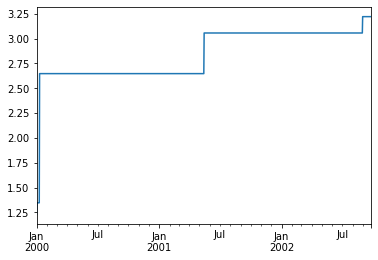

In [53]:
ks.options.plotting.backend = "matplotlib"

kser.plot()

**Gráficos de Pandas Bokeh**

In [55]:
pip install pandas_bokeh

In [54]:
ks.options.plotting.backend = "pandas_bokeh"

kdf.plot(backend="pandas_bokeh", title="Example Figure")
kser.plot()

ValueError: Could not find plotting backend 'pandas_bokeh'. Ensure that you've installed the package providing the 'pandas_bokeh' entrypoint, or that the package has a top-level `.plot` method.

**Gráfico por defecto con plotly**

In [ ]:
kser.plot()

En un DataFrame, el plot() es una conveniencia para trazar todas las columnas con etiquetas:

In [ ]:
pdf = pd.DataFrame(np.random.randn(1000, 4), index=pser.index,
                   columns=['A', 'B', 'C', 'D'])

In [ ]:
kdf = ks.from_pandas(pdf)

In [ ]:
kdf = kdf.cummax()
kdf

In [ ]:
kdf.plot()

### 6. Entrada / salida de datos


### CSV

CSV es sencillo y fácil de usar

In [ ]:
kdf.to_csv('foo.csv')
ks.read_csv('foo.csv').head(10)

### Parquet

Parquet es un formato de archivo eficiente y compacto para leer y escribir más rápido.

In [ ]:
kdf.to_parquet('bar.parquet')
ks.read_parquet('bar.parquet').head(10)

### Spark IO

Además, Koalas es totalmente compatible con las diversas fuentes de datos de Spark, como ORC y una fuente de datos externa.

In [ ]:
kdf.to_spark_io('zoo.orc', format="orc")
ks.read_spark_io('zoo.orc', format="orc").head(10)